In [1]:
#imports
#Imports
import numpy as np 
from numpy import pi
import matplotlib.pyplot as plt
import sciann as sn 
from sciann_datagenerator import *

---------------------- SCIANN 0.6.7.3 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.9.2 
Python Version: 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:14) 
[Clang 12.0.1 ] 

Outdated SciANN installation is found (V-0.6.7.3). Get the latest version (V-0.6.7.6):  
      > pip [--user] install --upgrade sciann  


Queremos una PINN que resuelva la ecuacion para un modelo de opinion tipo deffuant con heterogeneidad de los agentes. El modelo original es:

El dominio $K = [-1,1]\times [0,1]\times [0,1]$,  $\hat{\omega} in K$, $\hat{\omega} = (\omega, p, q)$

La ecuación, como está en el paper es
$$\frac{d}{d t} \int_K \phi (\hat{\omega}) d f_t(\omega) = \int_K \left( (m(t) - \omega) \langle p \rangle q  \right) \partial_\omega \phi(\hat{\omega}) d f_t(\omega)$$


donde $m(t) = \int_k \frac{\omega p}{\langle p \rangle}d f_t(\omega)$

Primero, hacemos un caso más sencillo donde $p=q=1$ siempre. La ecuación queda 

$$\frac{d}{d t} \int_K \phi (\omega) d f_t(\omega) = \int_K  (m(t) - \omega)  \partial_\omega \phi(\omega) d f_t(\omega)$$

y ahora $m(t) = m(0)$ para todo $t$.

La PDE queda

$$u_t (x) = \partial_x((m - x) u)$$
con condición de borde $u(t,-1) = u(t,1) = 0$ para todo tiempo $t$.

In [29]:
#Intervalo de tiempo
T= float(2)

dg = DataGeneratorXY([-1., 1.],[0., T], ["domain",'bc-bot','bc-left', 'bc-right'], 4000) #, "bc-right"]
input_data, target_data = dg.get_data()

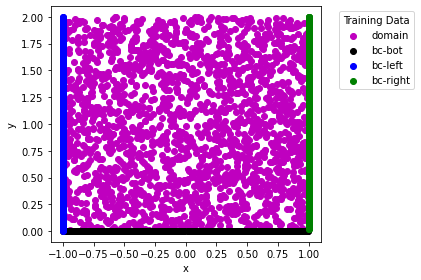

In [30]:
dg.plot_data()

In [31]:
#defino mis funcion y mis variables

#function variable
x = sn.Variable('x')

#initial condition. I treat it as a variable for the NN u.
t = sn.Variable('t')

u = sn.Functional('u', [x,t], hidden_layers = 4*[30], activation = 'tanh', res_net=True) #esta es la red neuronal cruda sin entrenar,

In [ ]:
#aca calculo el m el centro de masa de u

def m(u,t):
    x = np.linspace(-1,1,101)
    

In [38]:
#ahora defino la loss function para u

m = 0

#Pido que satisfaga la ecuacion
aux=sn.sub(x,m)
#aux = sn.mul(aux,-1)
L = sn.abs(sn.diff(u, t, order = 1) - sn.diff(sn.mul(u, aux), x, order=1)  )

#Dato inicial u(0) = e - x^2

#tomo una gaussiana como dato inicial. tiene media cero, que hardcodeo en la ecuacion
C1 = (t==0) *( sn.sub(u,sn.exp(- sn.pow(x,2)) - np.e**(-1)))

C2 = (x==-1) * sn.abs(u)
C3 = (x==1) * sn.abs(u)

#IC = (t==0.) * (sn.abs( sn.sub(u, np.e^(-x^2)) ))

Text(0.5, 1.0, 'Dato Inicial')

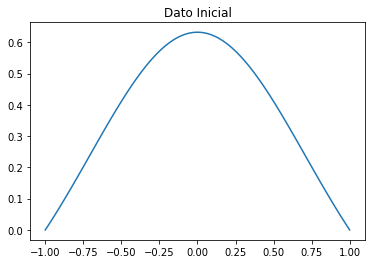

In [39]:
#ploteo el dato inicial

X= np.linspace(-1,1,100)
Y = [np.exp(-x**2) - np.e**(-1) for x in X ]
plt.plot(X,Y)
plt.title('Dato Inicial')

In [40]:
modelo = sn.SciModel([x,t], [L,C1, C2, C3], optimizer = 'adam') # C2, C3], optimizer = 'adam') #, C2, C3], optimizer = 'adam')


In [42]:
history = modelo.train(x_true = input_data, 
             y_true = target_data, 
             epochs = 30,
             learning_rate = 0.001,
             adaptive_weights={'method': 'NTK', 'freq':10, 'use_score':True})


Total samples: 5000 
Batch size: 64 
Total batches: 79 


+ NTK evaluation time [s]: 3.744320869445801 

+ adaptive_weights at epoch 1: [0.20405726702840762, 2.9931060217880536, 0.37917949638568593, 0.4236572147978526]
Epoch 1/30
79/79 [==============================] - 7s 51ms/step - batch: 39.0000 - size: 63.2911 - loss: 0.0237 - abs_8_loss: 0.1043 - mul_245_loss: 5.7791e-04 - mul_246_loss: 9.8622e-04 - mul_247_loss: 7.2299e-04 - lr: 0.0010 - time: 12.0084 - loss_weight_0: 0.2041 - loss_weight_1: 2.9931 - loss_weight_2: 0.3792 - loss_weight_3: 0.4237 - loss_gradient_0: 232.4334 - loss_gradient_1: 13.4968 - loss_gradient_2: 104.1794 - loss_gradient_3: 103.9025
Epoch 2/30
79/79 [==============================] - 2s 23ms/step - batch: 39.0000 - size: 63.2911 - loss: 0.0188 - abs_8_loss: 0.0839 - mul_245_loss: 3.8893e-04 - mul_246_loss: 7.7939e-04 - mul_247_loss: 5.2213e-04 - lr: 0.0010 - time: 1.8486 - loss_weight_0: 0.2041 - loss_weight_1: 2.9931 - loss_weight_2: 0.3792 - loss_weight_

In [43]:
#valores = np.arange(0,4,0.001)

valores = np.meshgrid(np.linspace(-1,1,100),np.linspace(0,T,200))
valores_y = u.eval(valores)

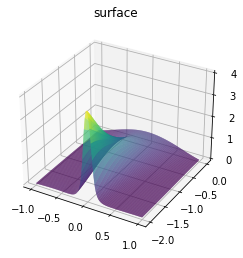

In [44]:
ax = plt.axes(projection='3d')
ax.plot_surface(valores[0], -1*valores[1], valores_y, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');


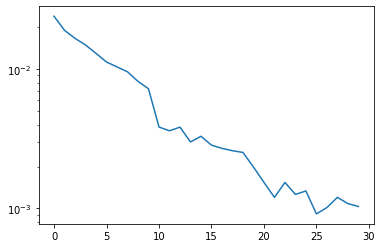

In [45]:
plt.semilogy(history.history['loss'])

Siguient paso. agregar el laplaciano $+\epsilon \Delta u$

va a haber que calcular $m(t) = \int_\Omega u(x,t) dx$